/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_63616/920301245.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  + pd.to_timedelta(df['new_hour'], 'H') \
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_63616/920301245.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  + pd.to_timedelta(df['new_hour'], 'H') \
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_63616/920301245.py:87: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from current font.
  plt.tight_layout()
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_63616/920301245.py:87: UserWarning: Glyph 35336 (\N{CJK UNIFIED IDEOGRAPH-8A08}) missing from current font.
  plt.tight_layout()
/Users/satoki252595/.pyenv/versions/3.11.7/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) mi

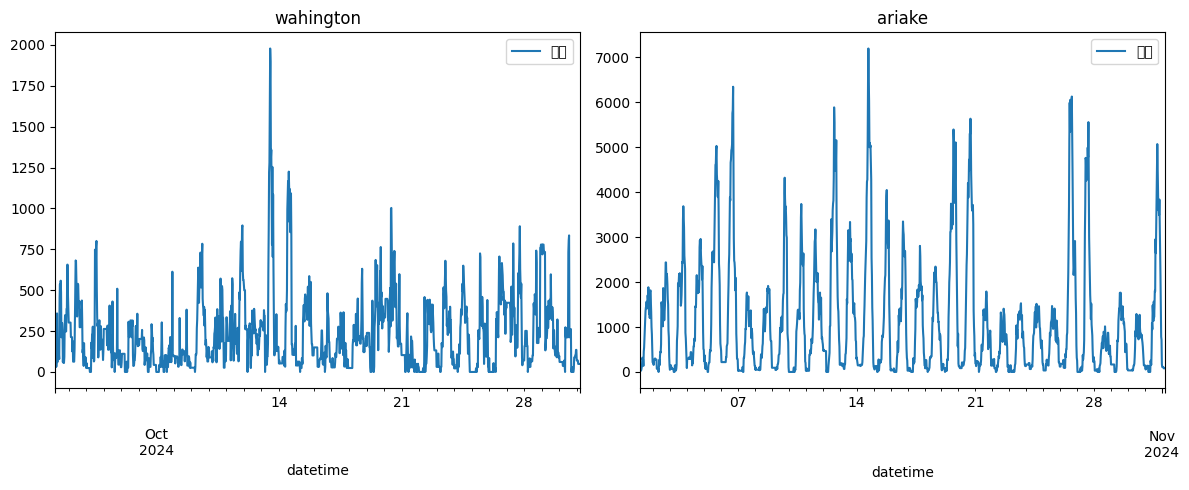

In [4]:
# 必要なライブラリのインポート
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sqlalchemy import create_engine

# PostgreSQLデータベースへの接続設定
db_config = {
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '54322',
    'database': 'postgres'
}

# SQLAlchemyエンジンの作成
engine = create_engine(f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

# データの読み込み
yahoomap_crawds_query = "SELECT * FROM yahoomap_crawds"
event_details_query = "SELECT * FROM event_details"
weather_history_hour_query = "SELECT * FROM weather_history_hour"

yahoomap_crawds = pd.read_sql(yahoomap_crawds_query, engine)
event_details = pd.read_sql(event_details_query, engine)
weather_history_hour = pd.read_sql(weather_history_hour_query, engine)

ariake_ = pd.read_csv('ariake.csv')
wahington_= pd.read_csv('wahington.csv')

def convert_time_to_hhmm(t):
    # "5時" -> hour=5, minute=00
    # "5時半" -> hour=5, minute=30
    # 数字部分(時)を抽出
    hour = int(t.split('時')[0])
    # 「半」が含まれているかで分を判定
    minute = 30 if '半' in t else 0
    
    # フォーマット：hhmm
    return f"{hour:02d}{minute:02d}"


wahington_['時間'] = wahington_['時間'].apply(convert_time_to_hhmm)
ariake_['時間'] = ariake_['時間'].apply(convert_time_to_hhmm)

wahington_ = wahington_[['日付', '時間', '合計']] 
ariake_ = ariake_[['日付', '時間', '合計']] 

def preprocess_df(df):
    # 日付カラムをdatetime型へ
    df['日付'] = pd.to_datetime(df['日付'])

    # 時間文字列を分解（例: "0530"-> hour=5, minute=30  "2630"-> hour=26, minute=30）
    df['hour'] = df['時間'].str[:-2].astype(int)   # 先頭から末2文字前までが時
    df['minute'] = df['時間'].str[-2:].astype(int) # 最後の2文字が分

    # 24時を超える場合に日付を繰り上げる処理
    # 総分数=hour*60+minute -> 日跨ぎ判定
    df['total_minutes'] = df['hour']*60 + df['minute']
    df['day_offset'] = df['total_minutes'] // 1440  # 1440分=24時間
    df['remain_minutes'] = df['total_minutes'] % 1440
    df['new_hour'] = df['remain_minutes'] // 60
    df['new_minute'] = df['remain_minutes'] % 60

    # 元の日付にday_offset日を足し、hour/minuteを加算
    df['datetime'] = df['日付'] + pd.to_timedelta(df['day_offset'], 'D') \
                                + pd.to_timedelta(df['new_hour'], 'H') \
                                + pd.to_timedelta(df['new_minute'], 'm')

    # 不要な中間列削除
    df.drop(columns=['hour','minute','total_minutes','day_offset','remain_minutes','new_hour','new_minute'], inplace=True)

    return df

wahington_ = preprocess_df(wahington_)
ariake_ = preprocess_df(ariake_)

import matplotlib.pyplot as plt

# プロット
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

wahington_.plot(x='datetime', y='合計', ax=axes[0], title='wahington')
ariake_.plot(x='datetime', y='合計', ax=axes[1], title='ariake')

plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def ML(df):
    # データフレームを 'df' とします。
    # df は以下のカラムを持つと想定:
    # '日付', '時間', '合計', 'datetime'
    # 'datetime'は既にpd.to_datetimeされている
    
    # datetime特徴量の抽出
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['dayofweek'] = df['datetime'].dt.dayofweek  # 月曜=0, 日曜=6
    
    # 目的変数と説明変数の分離
    X = df[['year','month','day','hour','minute','dayofweek']]  # datetime由来の特徴量
    y = df['合計']
    
    # 学習用・テスト用データに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # ランダムフォレスト回帰モデルの作成・学習
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # テストデータで予測
    y_pred = model.predict(X_test)
    
    # モデル評価(MSE, RMSEなど)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print("テストデータでのRMSE:", rmse)
    
    # 特徴量の重要度確認
    importances = model.feature_importances_
    for feat, imp in zip(X.columns, importances):
        print(f"{feat}: {imp:.3f}")

In [6]:
ML(wahington_)

テストデータでのRMSE: 106.53464192719453
year: 0.000
month: 0.000
day: 0.367
hour: 0.411
minute: 0.030
dayofweek: 0.192


In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


def ML(df):
    # df は 'datetime'列がpd.to_datetime済みとする

    # datetime特徴量の抽出
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['dayofweek'] = df['datetime'].dt.dayofweek

    X = df[['year','month','day','hour','minute','dayofweek']]
    y = df['合計']

    # 時系列クロスバリデーション
    tscv = TimeSeriesSplit(n_splits=5)

    mse_list = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)

    # 平均MSEおよびRMSE
    avg_mse = np.mean(mse_list)
    avg_rmse = np.sqrt(avg_mse)
    print("クロスバリデーション平均RMSE:", avg_rmse)

    # 最終学習(必要であれば最新データで再度学習)
    # 直近の学習データのみでモデルを再学習し、その性能評価や本番運用に使うなどの対応

    # 特徴量重要度の確認（最後のスプリットで学習したモデルなど）
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    for feat, imp in zip(X.columns, importances):
        print(f"{feat}: {imp:.3f}")

In [8]:
ML(wahington_)

クロスバリデーション平均RMSE: 249.85493361198613
year: 0.000
month: 0.000
day: 0.354
hour: 0.409
minute: 0.032
dayofweek: 0.205


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def ML(df):
    # datetime特徴量の抽出
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['dayofweek'] = df['datetime'].dt.dayofweek

    X = df[['year','month','day','hour','minute','dayofweek']]
    y = df['合計']

    # 学習・テスト分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    # shuffle=Falseとすることで、シャッフルせず、時系列順序を保った分割も可能
    # （データの並び順によるが、時系列順で並んでいる前提）

    # モデル学習
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # 評価指標
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print("テストデータでのRMSE:", rmse)

    # datetime軸の取得
    # X, y, dfは対応している前提で、X_testのインデックスを用いてdfからdatetimeを取得
    test_dates = df.loc[X_test.index, 'datetime']

    # 実データと予測データの重ね合わせ
    plt.figure(figsize=(12,6))
    plt.plot(test_dates, y_test, label='Actual', marker='o', linestyle='--')
    plt.plot(test_dates, y_pred, label='Predicted', marker='x')

    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

テストデータでのRMSE: 246.86907989455892


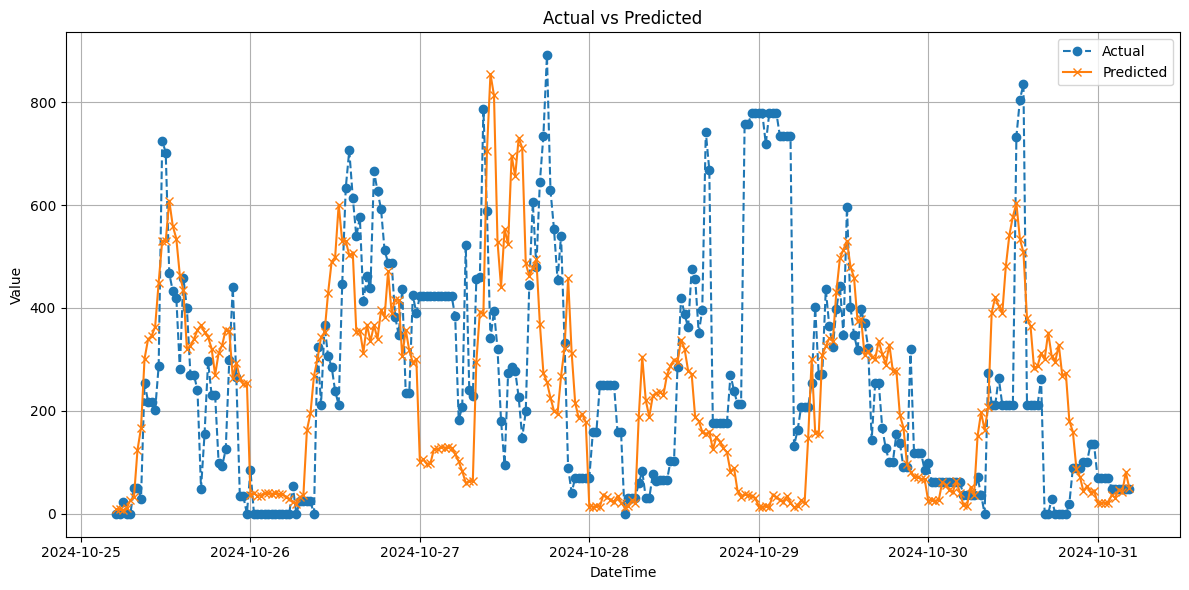

In [10]:
ML(wahington_)

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def ML(df):
    # datetime特徴量の抽出
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['dayofweek'] = df['datetime'].dt.dayofweek

    X = df[['year','month','day','hour','minute','dayofweek']]
    y = df['合計']

    # 時系列を保って分割（shuffle=Falseかつデータが時系列順になっている前提）
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )

    # モデル学習
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # 評価指標
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print("テストデータでのRMSE:", rmse)
    print("テストデータでのR2スコア:", r2)

    # テストデータのdatetime取得
    test_dates = df.loc[X_test.index, 'datetime']

    # 実データと予測データの重ね合わせ
    plt.figure(figsize=(12,6))
    plt.plot(test_dates, y_test, label='Actual', marker='o', linestyle='--')
    plt.plot(test_dates, y_pred, label='Predicted', marker='x')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 特徴量重要度のプロット
    importances = model.feature_importances_
    feature_names = X.columns
    # 特徴量を重要度の高い順にソート
    indices = np.argsort(importances)

    plt.figure(figsize=(8,6))
    plt.barh(feature_names[indices], importances[indices], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

    # 実値vs予測値の散布図
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Scatter Plot')
    plt.grid(True)
    # 対角線描画(理想的にはy=x上に点が並ぶ)
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.plot([min_val, max_val],[min_val, max_val], 'r--')
    plt.tight_layout()
    plt.show()

    # 残差プロット（残差 = 実値 - 予測値）
    residuals = y_test - y_pred
    plt.figure(figsize=(6,6))
    plt.scatter(y_pred, residuals, alpha=0.7, color='purple')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title('Residual Plot')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 残差の分布プロット（誤差の分布）
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True, color='green')
    plt.title('Residual Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

テストデータでのRMSE: 246.86907989455892
テストデータでのR2スコア: -0.20315061027950088


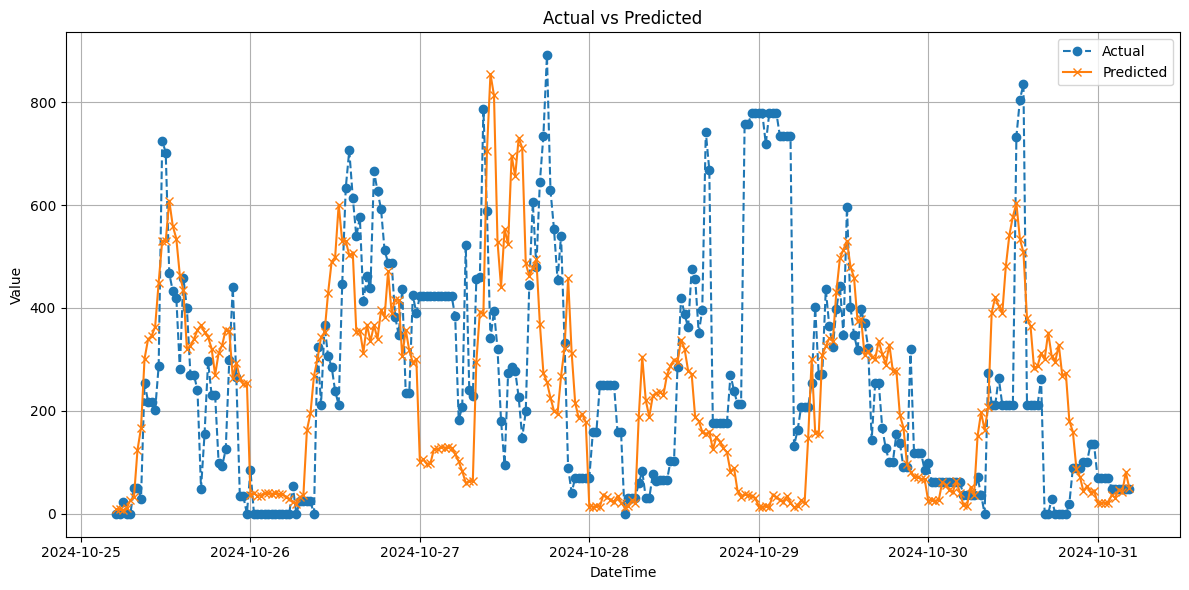

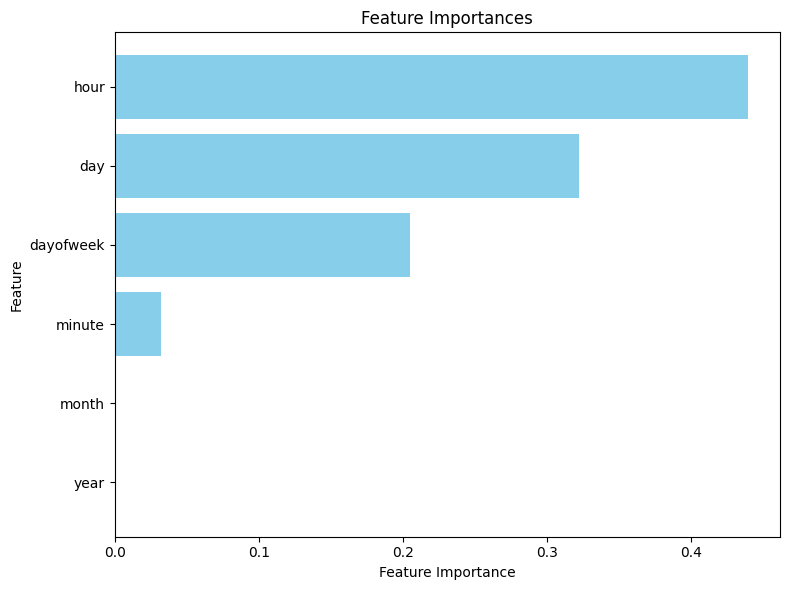

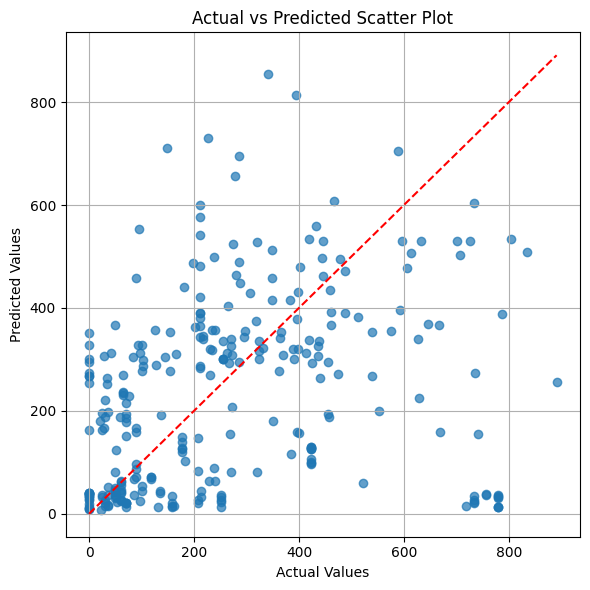

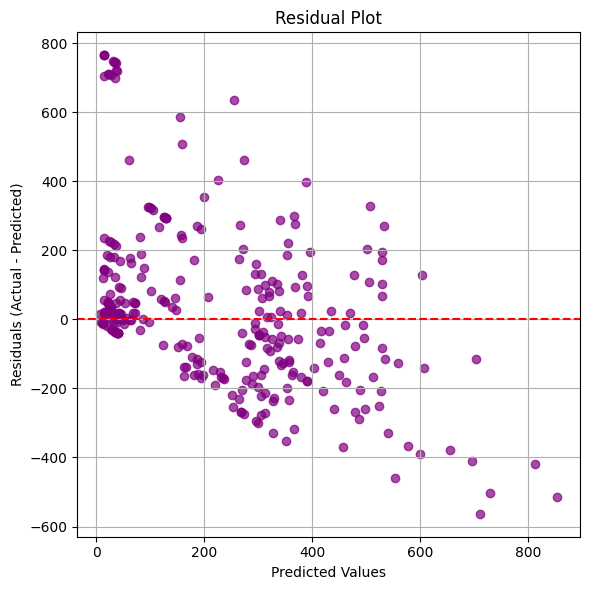

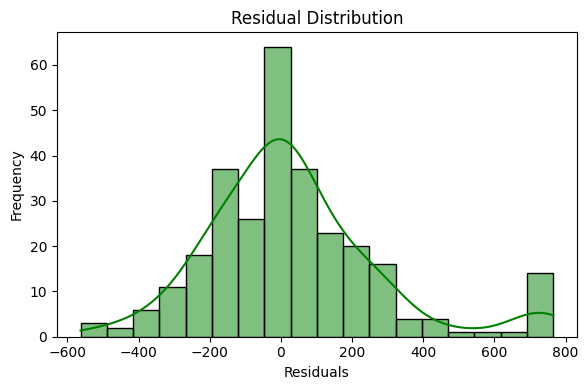

In [12]:
ML(wahington_)

テストデータでのRMSE: 875.4339428233951
テストデータでのR2スコア: 0.6365393537234407


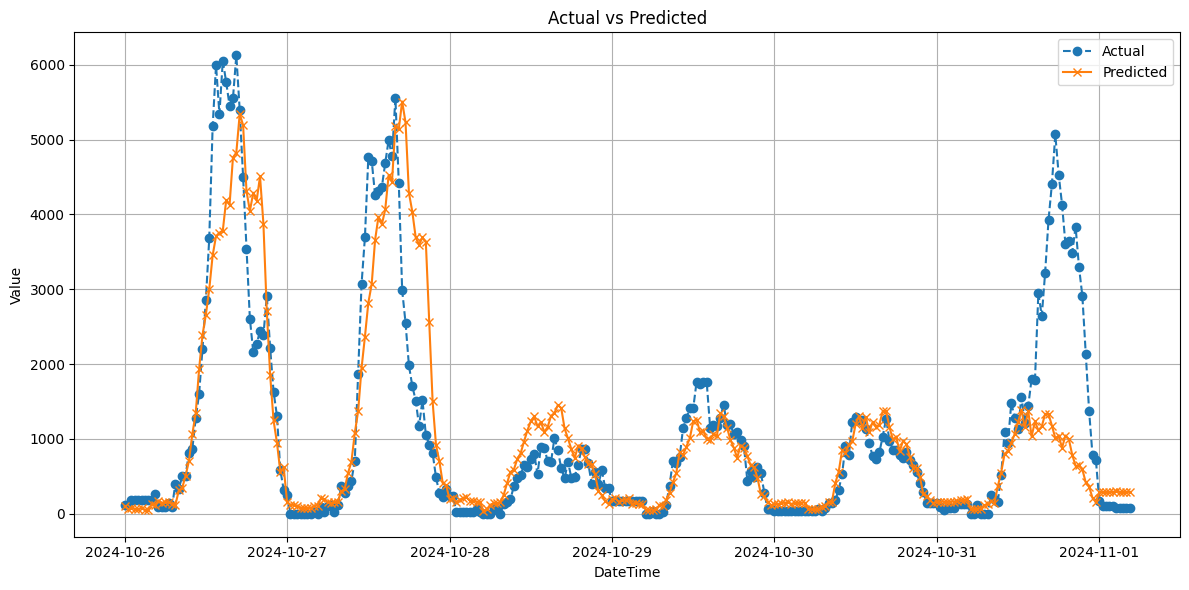

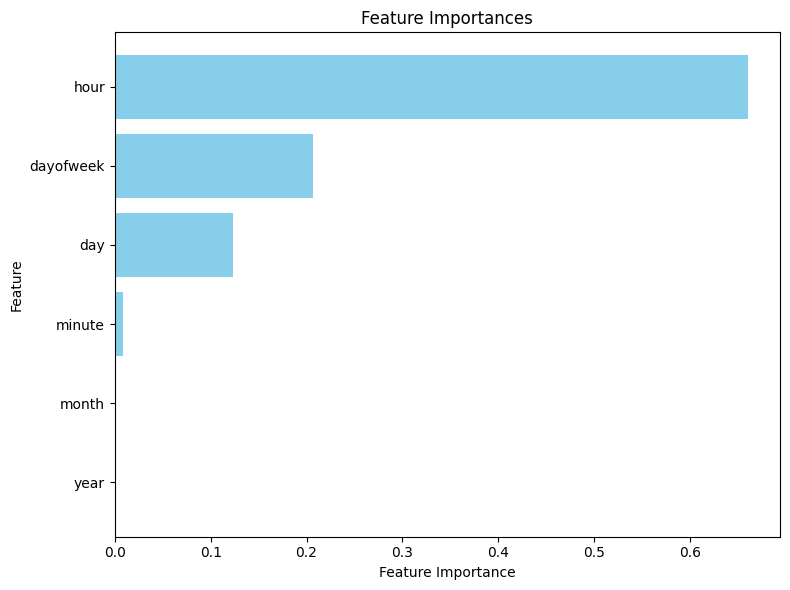

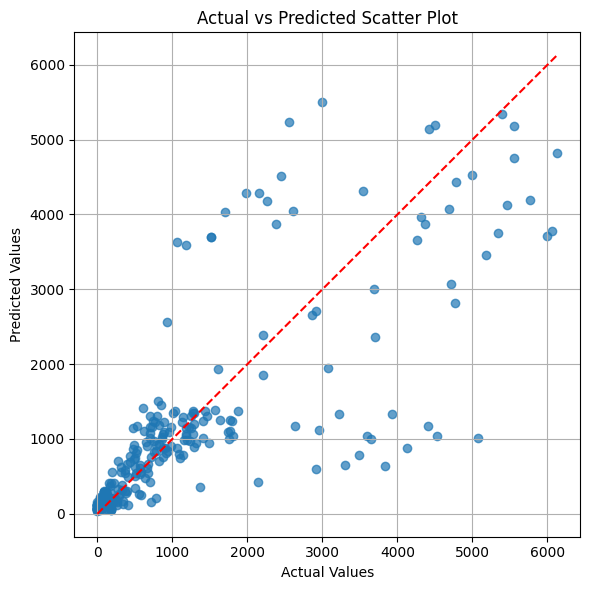

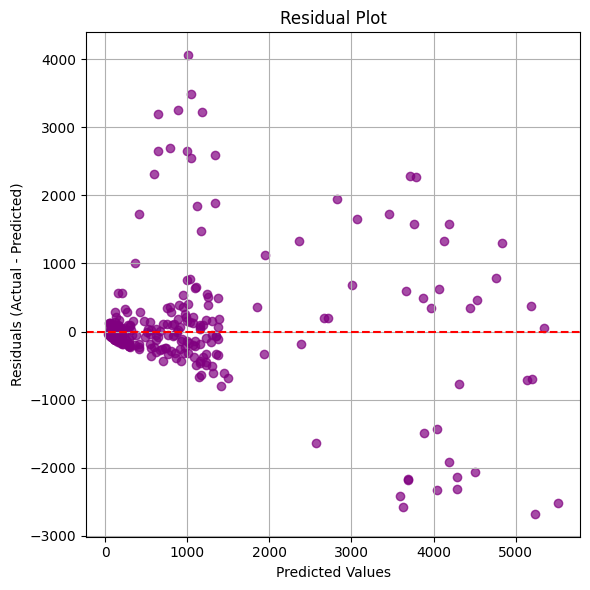

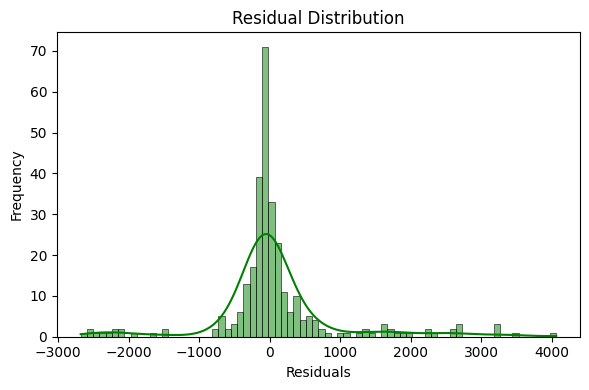

In [13]:
ML(ariake_)

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

def create_lag_features(df, lags=[1,24]):
    for lag in lags:
        df[f'lag_{lag}'] = df['合計'].shift(lag)
    return df

def create_rolling_features(df, windows=[3,24]):
    for w in windows:
        df[f'rolling_mean_{w}'] = df['合計'].shift(1).rolling(w).mean()
        df[f'rolling_std_{w}'] = df['合計'].shift(1).rolling(w).std()
    return df

def add_time_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    # 周期性の例：曜日を2πで正規化し、sin/cos変換
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    return df

def ML(df):
    # 前処理
    df = df.dropna(subset=['datetime', '合計']).copy()
    df = df.sort_values('datetime')  # 時系列順に並び替え
    df = add_time_features(df)

    # 遅れ特徴量・移動統計特徴量の作成
    df = create_lag_features(df, lags=[1,24])
    df = create_rolling_features(df, windows=[3,24])

    # ラグ特徴量生成後のNaN行削除
    df = df.dropna().copy()

    feature_cols = [
        'year','month','day','hour','dayofweek','dow_sin','dow_cos',
        'lag_1','lag_24',
        'rolling_mean_3','rolling_std_3','rolling_mean_24','rolling_std_24'
    ]
    X = df[feature_cols]
    y = df['合計']

    tscv = TimeSeriesSplit(n_splits=5)

    mse_list = []
    r2_list = []

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'n_estimators': 300,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'verbosity': -1  # Warning非表示
    }

    # 時系列CV
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2)

    avg_mse = np.mean(mse_list)
    avg_rmse = np.sqrt(avg_mse)
    avg_r2 = np.mean(r2_list)
    print("クロスバリデーション平均RMSE:", avg_rmse)
    print("クロスバリデーション平均R²:", avg_r2)

    # 最終スプリット(最後の分割)での可視化
    X_train_final, X_test_final = X.iloc[train_index], X.iloc[test_index]
    y_train_final, y_test_final = y.iloc[train_index], y.iloc[test_index]

    model_final = lgb.LGBMRegressor(**params)
    model_final.fit(X_train_final, y_train_final)
    y_pred_final = model_final.predict(X_test_final)

    final_mse = mean_squared_error(y_test_final, y_pred_final)
    final_rmse = np.sqrt(final_mse)
    final_r2 = r2_score(y_test_final, y_pred_final)

    print("最後のスプリットでのRMSE:", final_rmse)
    print("最後のスプリットでのR²:", final_r2)

    test_dates = df.iloc[test_index]['datetime']

    # 実データと予測データの比較プロット
    plt.figure(figsize=(12,6))
    plt.plot(test_dates, y_test_final.values, label='Actual', marker='o', linestyle='--')
    plt.plot(test_dates, y_pred_final, label='Predicted', marker='x')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted (Last Fold)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 特徴量重要度
    importances = model_final.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(8,6))
    plt.barh(np.array(feature_cols)[indices], importances[indices], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

    # 実値vs予測値散布図
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_final, y_pred_final, alpha=0.7)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Scatter Plot (Last Fold)')
    plt.grid(True)
    min_val = min(min(y_test_final), min(y_pred_final))
    max_val = max(max(y_test_final), max(y_pred_final))
    plt.plot([min_val, max_val],[min_val, max_val], 'r--')
    plt.tight_layout()
    plt.show()

    # 残差プロット
    residuals = y_test_final - y_pred_final
    plt.figure(figsize=(6,6))
    plt.scatter(y_pred_final, residuals, alpha=0.7, color='purple')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot (Last Fold)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 残差分布
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True, color='green')
    plt.title('Residual Distribution (Last Fold)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

クロスバリデーション平均RMSE: 159.33269030949165
クロスバリデーション平均R²: 0.5583382589522505
最後のスプリットでのRMSE: 142.344230017109
最後のスプリットでのR²: 0.6072713814141597


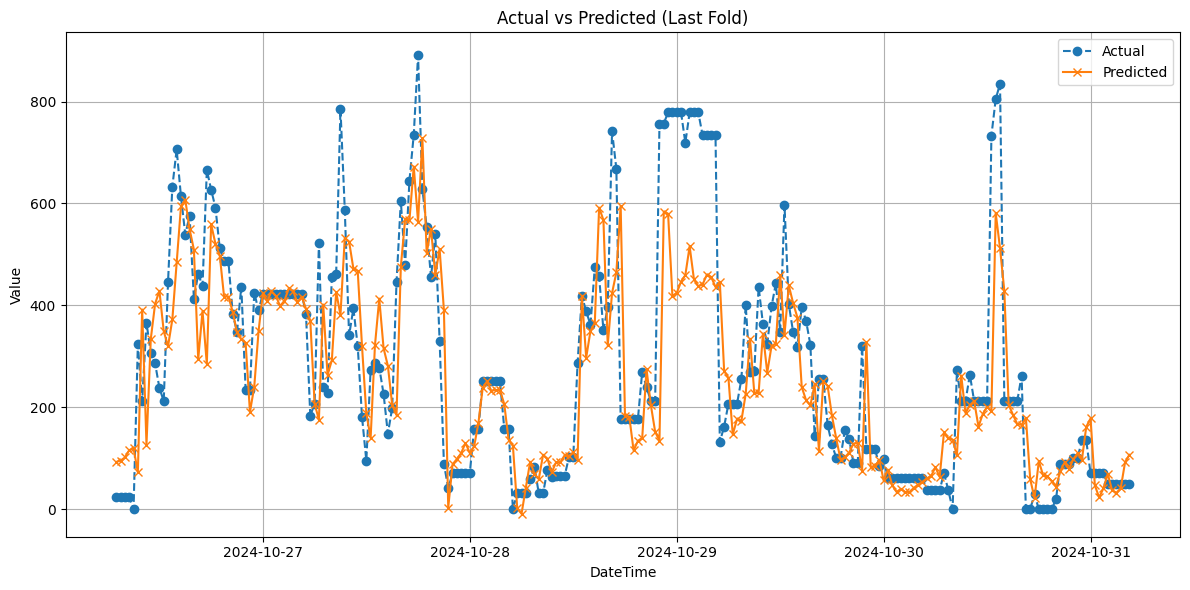

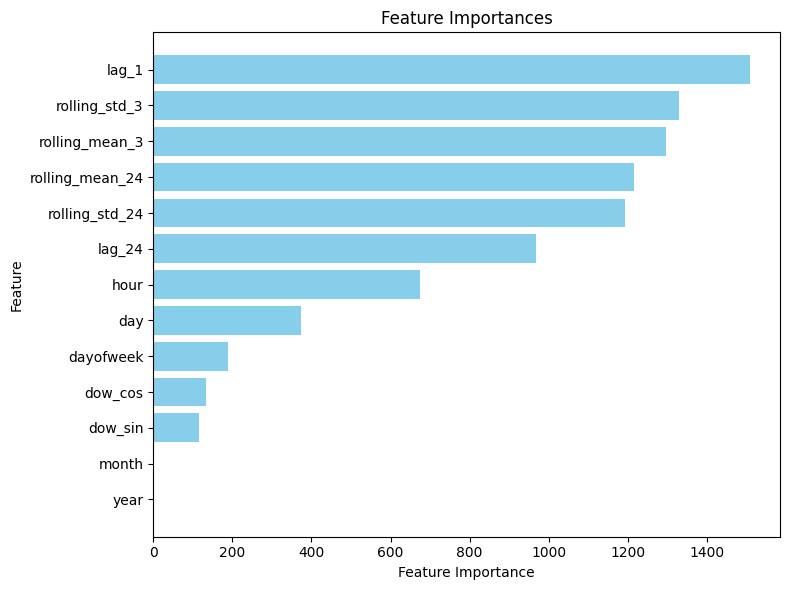

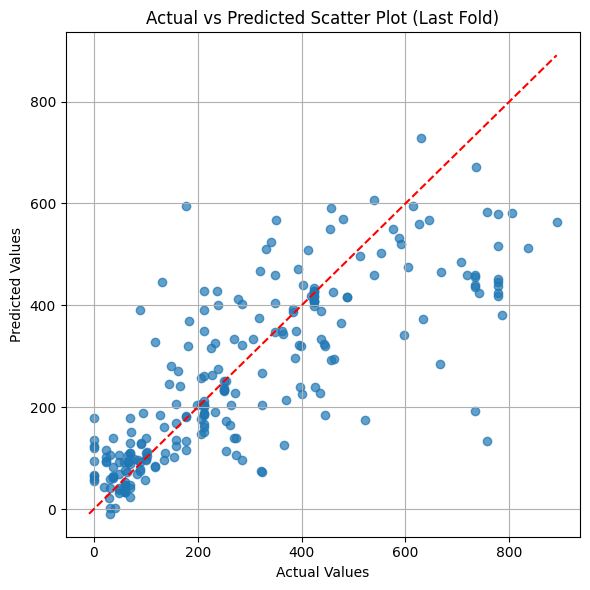

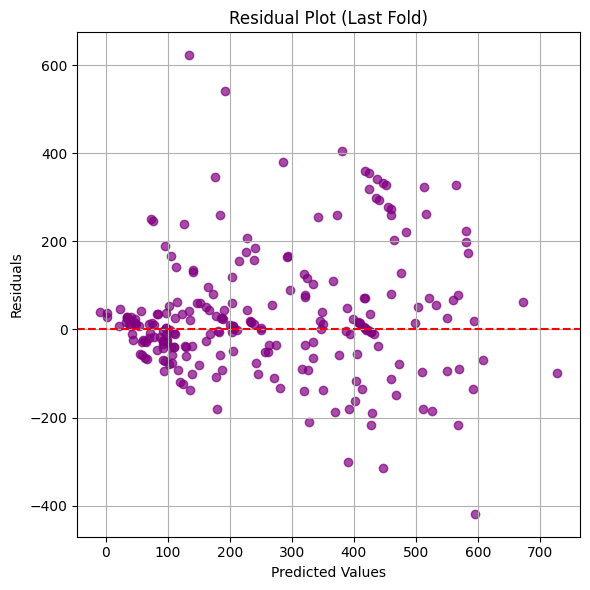

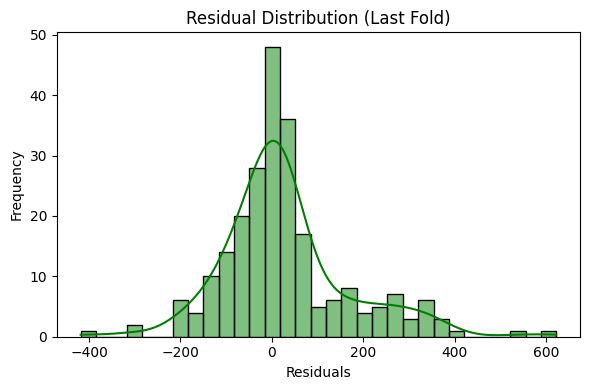

In [18]:
ML(wahington_)

クロスバリデーション平均RMSE: 332.29477913532753
クロスバリデーション平均R²: 0.9255552374857017
最後のスプリットでのRMSE: 278.9029579313956
最後のスプリットでのR²: 0.9484763846681228


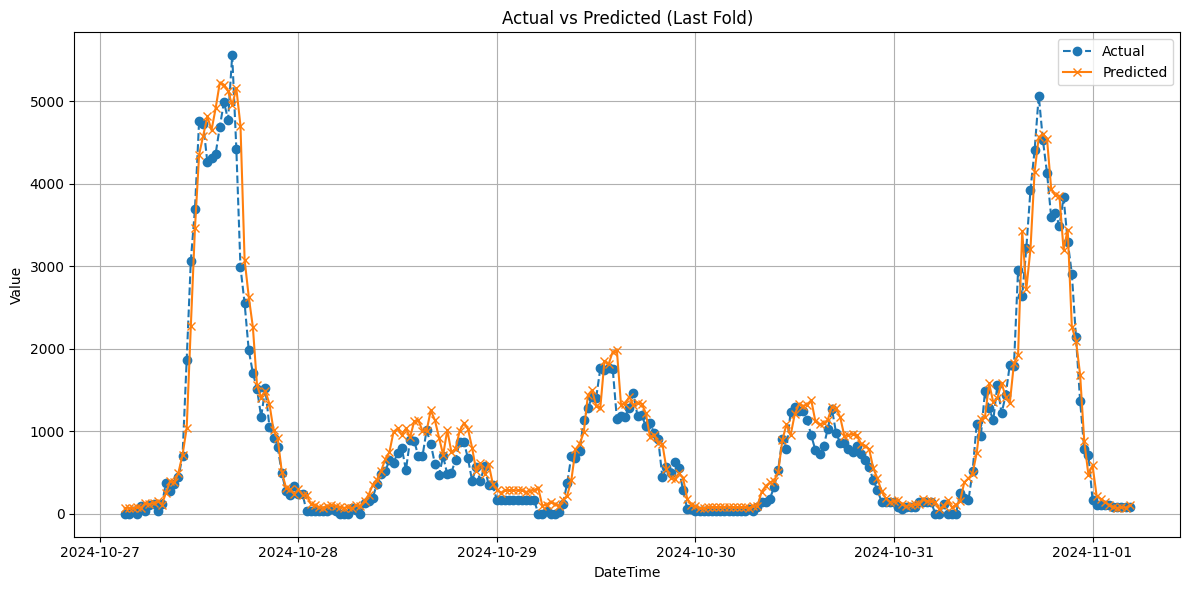

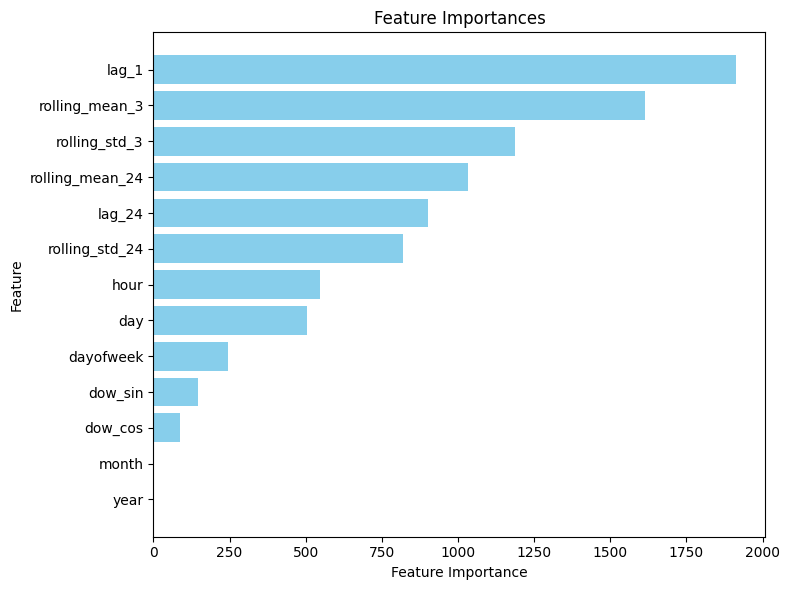

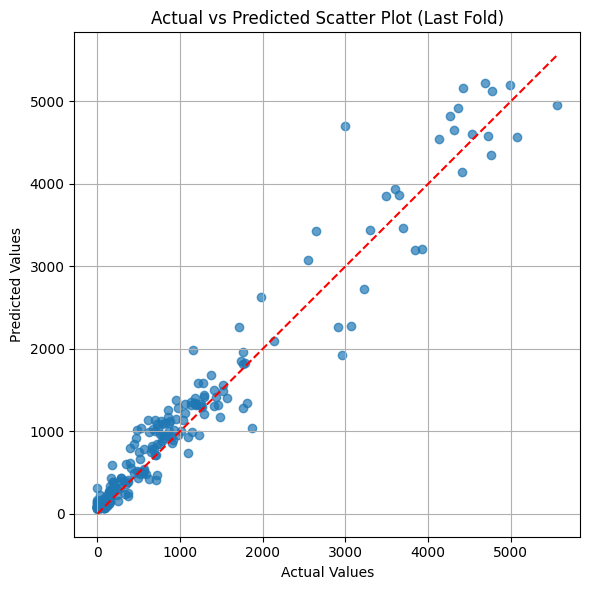

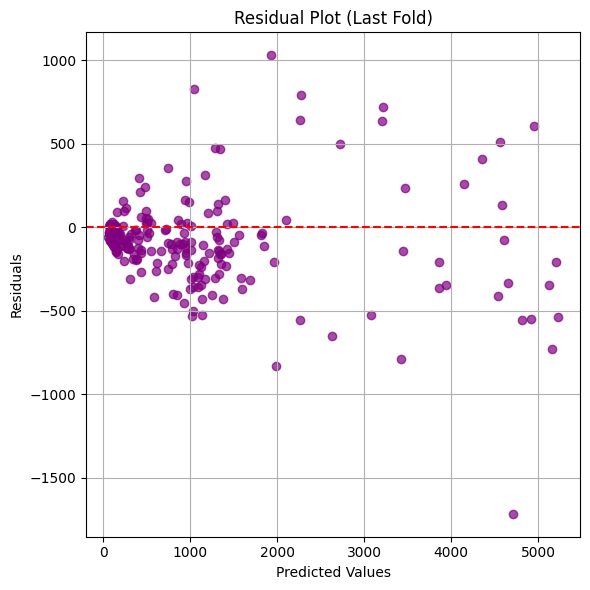

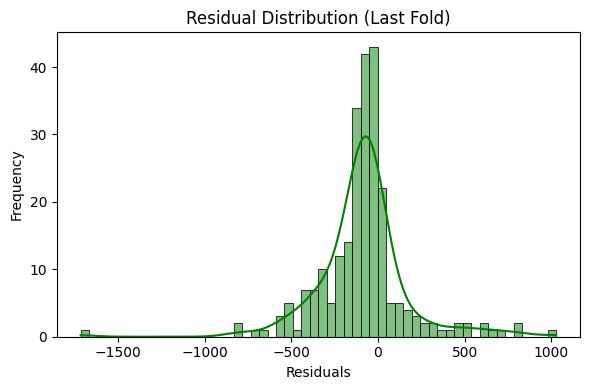

In [19]:
ML(ariake_)

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import datetime

def create_lag_features(df, lags=[1,24]):
    for lag in lags:
        df[f'lag_{lag}'] = df['合計'].shift(lag)
    return df

def create_rolling_features(df, windows=[3,24]):
    for w in windows:
        df[f'rolling_mean_{w}'] = df['合計'].shift(1).rolling(w).mean()
        df[f'rolling_std_{w}'] = df['合計'].shift(1).rolling(w).std()
    return df

def add_time_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    
    # 曜日をsin, cos変換
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    return df

def ML(df):
    # 2024年の日本の祝日リスト(振替休日含む)
    holidays_2024 = {
        datetime.date(2024,1,1),
        datetime.date(2024,1,8),
        datetime.date(2024,2,11),
        datetime.date(2024,2,12),
        datetime.date(2024,2,23),
        datetime.date(2024,3,20),
        datetime.date(2024,4,29),
        datetime.date(2024,5,3),
        datetime.date(2024,5,4),
        datetime.date(2024,5,5),
        datetime.date(2024,5,6),
        datetime.date(2024,7,15),
        datetime.date(2024,8,11),
        datetime.date(2024,8,12),
        datetime.date(2024,9,16),
        datetime.date(2024,9,22),
        datetime.date(2024,9,23),
        datetime.date(2024,10,14),
        datetime.date(2024,11,3),
        datetime.date(2024,11,4),
        datetime.date(2024,11,23)
    }

    # 前処理
    df = df.dropna(subset=['datetime', '合計']).copy()
    df = df.sort_values('datetime')
    df = add_time_features(df)

    # 祝日の判定と処理: 祝日であればdayofweekを7(休日)とする
    df.loc[df['datetime'].dt.date.isin(holidays_2024), 'dayofweek'] = 7

    # 過去・移動特徴量作成
    df = create_lag_features(df, lags=[1,24])
    df = create_rolling_features(df, windows=[3,24])
    df = df.dropna().copy()

    feature_cols = [
        'year','month','day','hour','dayofweek','dow_sin','dow_cos',
        'lag_1','lag_24',
        'rolling_mean_3','rolling_std_3','rolling_mean_24','rolling_std_24'
    ]
    X = df[feature_cols]
    y = df['合計']

    tscv = TimeSeriesSplit(n_splits=3)

    mse_list = []
    r2_list = []

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'n_estimators': 300,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'verbosity': -1  # Warning抑制
    }

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2)

    avg_mse = np.mean(mse_list)
    avg_rmse = np.sqrt(avg_mse)
    avg_r2 = np.mean(r2_list)
    print("クロスバリデーション平均RMSE:", avg_rmse)
    print("クロスバリデーション平均R²:", avg_r2)

    # 最終スプリットでの評価可視化
    X_train_final, X_test_final = X.iloc[train_index], X.iloc[test_index]
    y_train_final, y_test_final = y.iloc[train_index], y.iloc[test_index]

    model_final = lgb.LGBMRegressor(**params)
    model_final.fit(X_train_final, y_train_final)
    y_pred_final = model_final.predict(X_test_final)

    final_mse = mean_squared_error(y_test_final, y_pred_final)
    final_rmse = np.sqrt(final_mse)
    final_r2 = r2_score(y_test_final, y_pred_final)

    print("最後のスプリットでのRMSE:", final_rmse)
    print("最後のスプリットでのR²:", final_r2)

    test_dates = df.iloc[test_index]['datetime']

    # 実データと予測データの比較プロット
    plt.figure(figsize=(12,6))
    plt.plot(test_dates, y_test_final.values, label='Actual', marker='o', linestyle='--')
    plt.plot(test_dates, y_pred_final, label='Predicted', marker='x')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted (Last Fold)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 特徴量重要度
    importances = model_final.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(8,6))
    plt.barh(np.array(feature_cols)[indices], importances[indices], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()
    

クロスバリデーション平均RMSE: 175.01438161788076
クロスバリデーション平均R²: 0.5277243143252016
最後のスプリットでのRMSE: 124.86511696961587
最後のスプリットでのR²: 0.6803316996531849


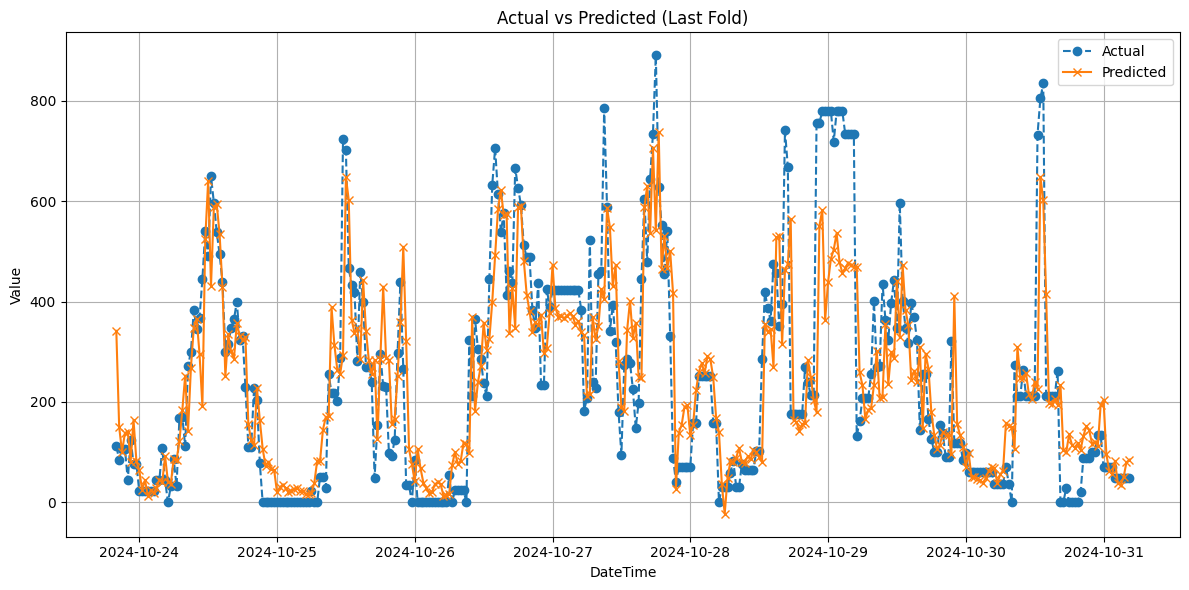

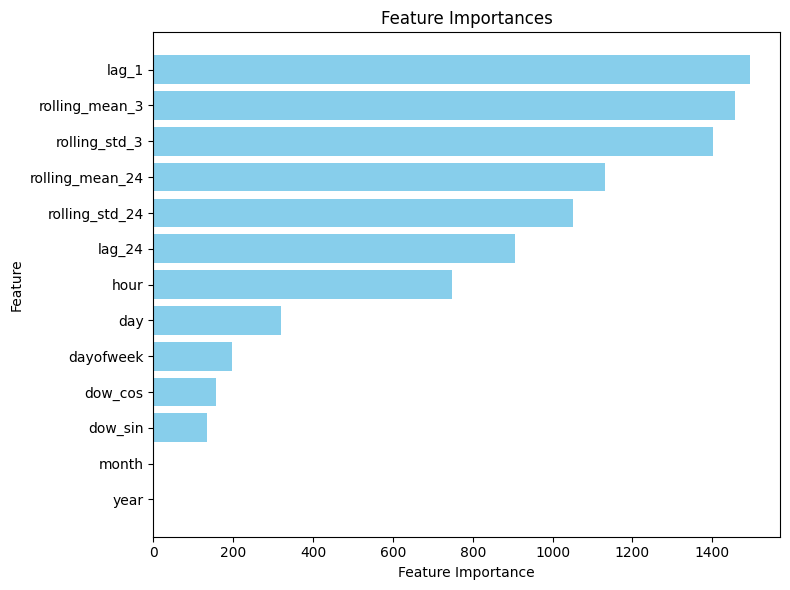

In [29]:
ML(wahington_)

クロスバリデーション平均RMSE: 318.26376588854635
クロスバリデーション平均R²: 0.9453142090696257
最後のスプリットでのRMSE: 286.3220813585949
最後のスプリットでのR²: 0.9539239601539505


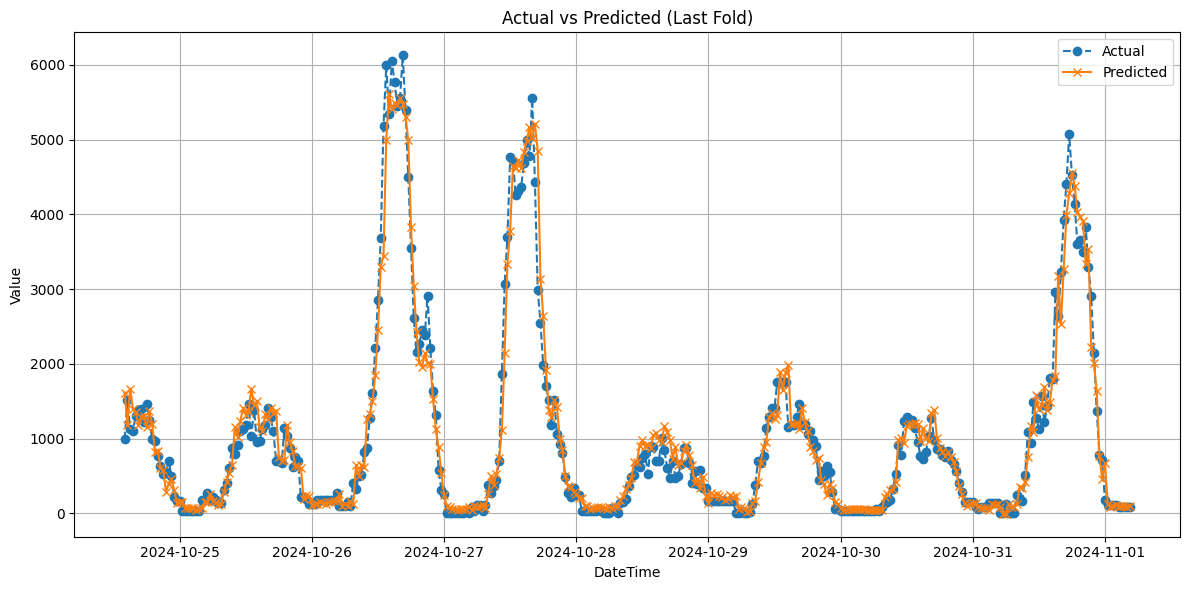

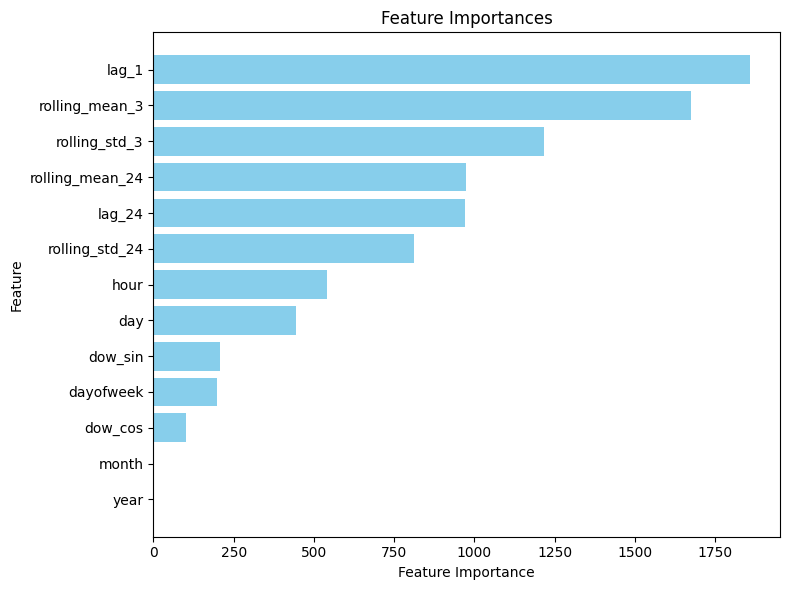

In [30]:
ML(ariake_)

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import datetime

def create_lag_features(df, lags=[1,24]):
    for lag in lags:
        df[f'lag_{lag}'] = df['合計'].shift(lag)
    return df

def create_rolling_features(df, windows=[3,24]):
    for w in windows:
        df[f'rolling_mean_{w}'] = df['合計'].shift(1).rolling(w).mean()
        df[f'rolling_std_{w}'] = df['合計'].shift(1).rolling(w).std()
    return df

def add_time_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    # 曜日をsin, cos変換
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    return df

def ML(df):
    # 2024年の日本の祝日リスト(振替休日含む)
    holidays_2024 = {
        datetime.date(2024,1,1),
        datetime.date(2024,1,8),
        datetime.date(2024,2,11),
        datetime.date(2024,2,12),
        datetime.date(2024,2,23),
        datetime.date(2024,3,20),
        datetime.date(2024,4,29),
        datetime.date(2024,5,3),
        datetime.date(2024,5,4),
        datetime.date(2024,5,5),
        datetime.date(2024,5,6),
        datetime.date(2024,7,15),
        datetime.date(2024,8,11),
        datetime.date(2024,8,12),
        datetime.date(2024,9,16),
        datetime.date(2024,9,22),
        datetime.date(2024,9,23),
        datetime.date(2024,10,14),
        datetime.date(2024,11,3),
        datetime.date(2024,11,4),
        datetime.date(2024,11,23)
    }

    # 前処理
    df = df.dropna(subset=['datetime', '合計']).copy()
    df = df.sort_values('datetime')
    df = add_time_features(df)
    
    # 祝日を休日として扱う
    df.loc[df['datetime'].dt.date.isin(holidays_2024), 'dayofweek'] = 7

    df = create_lag_features(df, lags=[1,24])
    df = create_rolling_features(df, windows=[3,24])
    df = df.dropna().copy()

    feature_cols = [
        'year','month','day','hour','dayofweek','dow_sin','dow_cos',
        'lag_1','lag_24',
        'rolling_mean_3','rolling_std_3','rolling_mean_24','rolling_std_24'
    ]
    X = df[feature_cols]
    y = df['合計']

    # データを1:1で分割（前半がtrain、後半がtest）
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'n_estimators': 300,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'verbosity': -1  # Warning抑制
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print("RMSE:", rmse)
    print("R²:", r2)

    test_dates = df.loc[X_test.index, 'datetime']

    # 実データと予測データの比較プロット
    plt.figure(figsize=(12,6))
    plt.plot(test_dates, y_test.values, label='Actual', marker='o', linestyle='--')
    plt.plot(test_dates, y_pred, label='Predicted', marker='x')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 特徴量重要度
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(8,6))
    plt.barh(np.array(feature_cols)[indices], importances[indices], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

RMSE: 172.2188195105355
R²: 0.48703899936918715


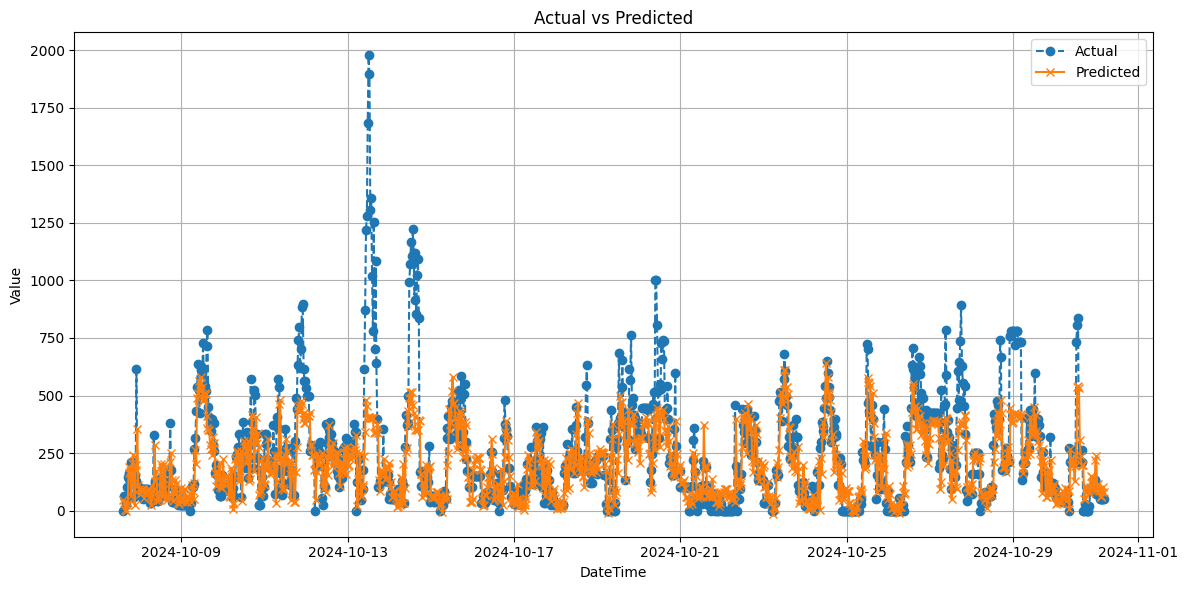

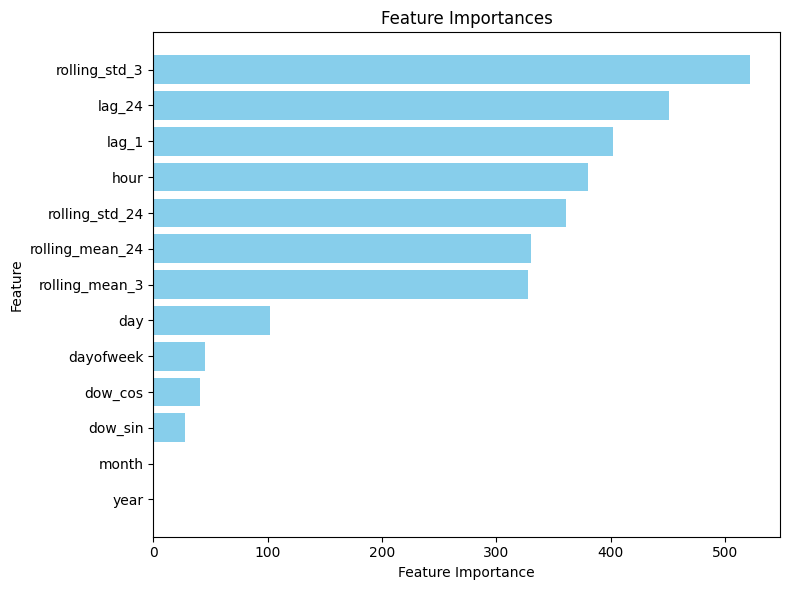

In [41]:
ML(wahington_)

RMSE: 250.99124823977343
R²: 0.9457047128532732


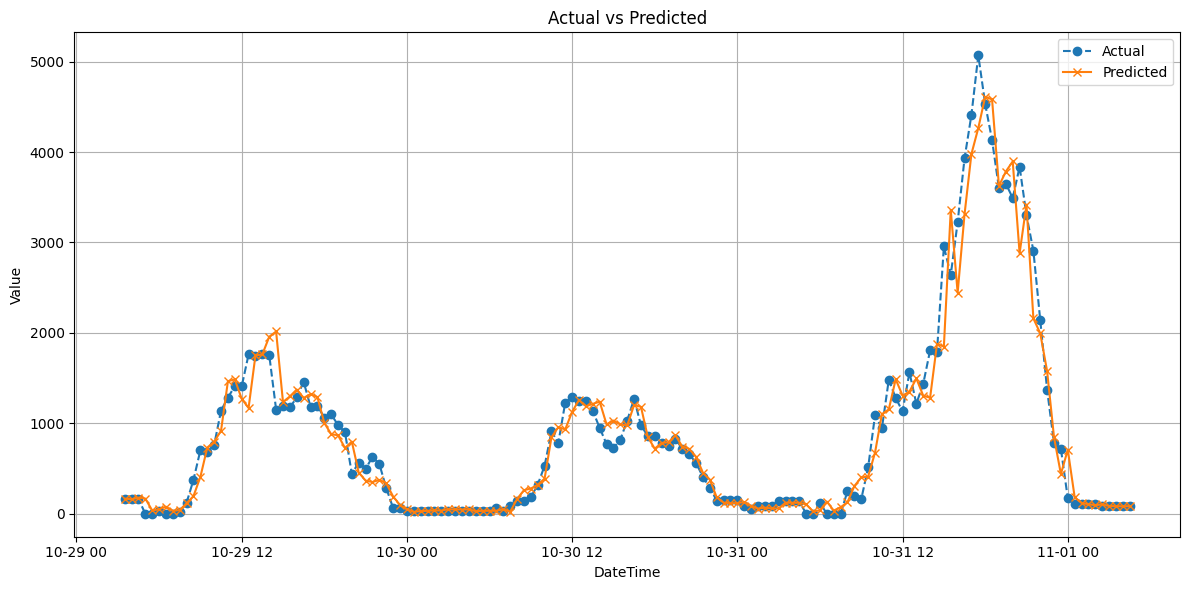

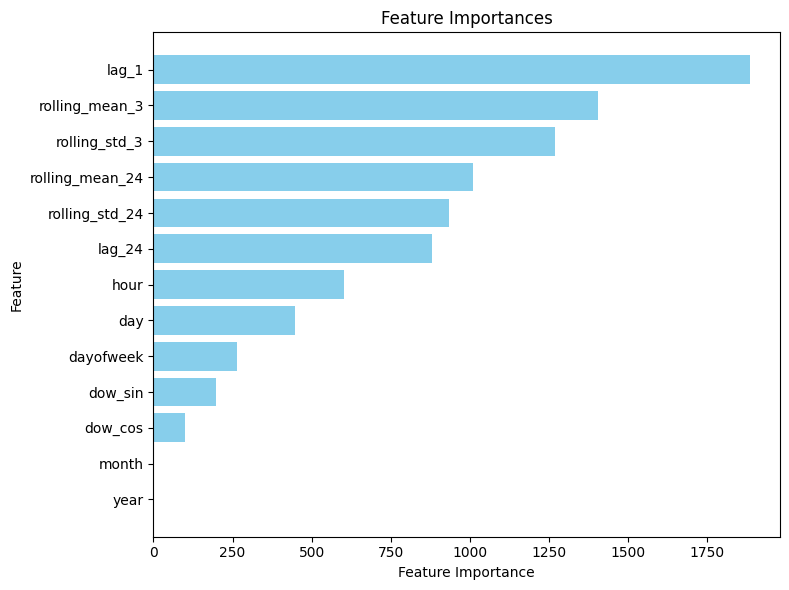

In [39]:
ML(ariake_)

In [46]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import optuna

def add_time_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    # 周期表現
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    return df

def create_lag_features(df, lags=[1,24,168]):
    # lags=[1,24,168]等により1時間前、24時間前(1日前)、168時間前(1週間前)を参照
    for lag in lags:
        df[f'lag_{lag}'] = df['target'].shift(lag)
    return df

def create_rolling_features(df, windows=[3,24,168]):
    # 異なる時間幅での移動平均・移動標準偏差
    for w in windows:
        df[f'rolling_mean_{w}'] = df['target'].shift(1).rolling(w).mean()
        df[f'rolling_std_{w}'] = df['target'].shift(1).rolling(w).std()
    return df

def create_seasonal_features(df):
    # 前年同日時刻、前週同日時刻など
    # 前年同日同時刻(8760時間前: 365日*24時間)
    df['lag_1year'] = df['target'].shift(8760)
    # 前週同日同時刻(168時間前は上記ですでに作成)
    # 他にも、前月同日同時刻(720時間前程度)などドメインに応じ追加可能
    return df

def add_holiday_features(df, holidays_2024):
    # 祝日当日
    df['is_holiday'] = df['datetime'].dt.date.isin(holidays_2024).astype(int)
    # 祝日前日・翌日フラグ
    df['is_holiday_before'] = df['datetime'].dt.date.isin(
        {d - datetime.timedelta(days=1) for d in holidays_2024}
    ).astype(int)
    df['is_holiday_after'] = df['datetime'].dt.date.isin(
        {d + datetime.timedelta(days=1) for d in holidays_2024}
    ).astype(int)

    # dayofweekを祝日で上書きする場合（既存のやり方）
    df.loc[df['is_holiday'] == 1, 'dayofweek'] = 7
    return df

def handle_outliers(df):
    # ターゲット値を対数変換（+1でshiftして0回避）
    df['target_log'] = np.log1p(df['target'])
    return df

def prepare_features(df):
    df = add_time_features(df)
    df = handle_outliers(df)  # 対数変換

    # 対数変換した列を元に特徴量作成
    df = df.rename(columns={'target_log': 'target_trans'})
    # ラグ・ロールは対数変換した値を用いる？
    # ここでは元のtargetを使うか、対数変換値を使うかは要検討
    # 一旦対数変換後の値を予測対象とするので、ラグ・ロールは対数値を元に計算
    df['target'] = df['target_trans']
    df = create_lag_features(df, lags=[1,24,168])
    df = create_rolling_features(df, windows=[3,24,168])
    df = create_seasonal_features(df)
    df = df.dropna().copy()

    return df

def objective(trial, X, y, splits):
    # ハイパーパラメータ探索
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'verbosity': -1
    }

    mse_list = []
    for train_index, test_index in splits.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse_list.append(mean_squared_error(y_test, y_pred))

    return np.mean(mse_list)

def ML(df):
    # 2024年の日本の祝日リスト(振替休日含む)
    holidays_2024 = {
        datetime.date(2024,1,1),
        datetime.date(2024,1,8),
        datetime.date(2024,2,11),
        datetime.date(2024,2,12),
        datetime.date(2024,2,23),
        datetime.date(2024,3,20),
        datetime.date(2024,4,29),
        datetime.date(2024,5,3),
        datetime.date(2024,5,4),
        datetime.date(2024,5,5),
        datetime.date(2024,5,6),
        datetime.date(2024,7,15),
        datetime.date(2024,8,11),
        datetime.date(2024,8,12),
        datetime.date(2024,9,16),
        datetime.date(2024,9,22),
        datetime.date(2024,9,23),
        datetime.date(2024,10,14),
        datetime.date(2024,11,3),
        datetime.date(2024,11,4),
        datetime.date(2024,11,23)
    }

    # 前処理
    df = df.dropna(subset=['datetime', '合計']).copy()
    df = df.sort_values('datetime')
    # ターゲットをコピーして使いやすい列名に
    df['target'] = df['合計']
    df = add_holiday_features(df, holidays_2024)
    df = prepare_features(df)
    # 特徴量選択
    # 対数変換後のtargetを予測するのでyは対数値
    y = df['target'] 
    # 'target','target_trans','合計'など不要列削除（元targetは処理済みのため）
    use_cols = [c for c in df.columns if c not in ['合計', 'target_trans', 'target', 'datetime']]
    X = df[use_cols]

    # 時系列クロスバリデーション
    tscv = TimeSeriesSplit(n_splits=3)

    # Optunaでハイパーパラメータ最適化
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, tscv), n_trials=20)
    print("Best params:", study.best_params)
    print("Best value (MSE):", study.best_value)

    # 最適パラメータでモデル再学習・評価
    best_params = study.best_params
    best_params.update({
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'verbosity': -1
    })

    mse_list = []
    r2_list = []
    folds = list(tscv.split(X))
    for train_index, test_index in folds:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = lgb.LGBMRegressor(**best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2_val = r2_score(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2_val)

    avg_mse = np.mean(mse_list)
    avg_rmse = np.sqrt(avg_mse)
    avg_r2 = np.mean(r2_list)
    print("TimeSeriesSplit平均RMSE:", avg_rmse)
    print("TimeSeriesSplit平均R²:", avg_r2)

    # 最終スプリットでの可視化
    final_train_index, final_test_index = folds[-1]
    X_train_final, X_test_final = X.iloc[final_train_index], X.iloc[final_test_index]
    y_train_final, y_test_final = y.iloc[final_train_index], y.iloc[final_test_index]

    model_final = lgb.LGBMRegressor(**best_params)
    model_final.fit(X_train_final, y_train_final)
    y_pred_final = model_final.predict(X_test_final)

    final_mse = mean_squared_error(y_test_final, y_pred_final)
    final_rmse = np.sqrt(final_mse)
    final_r2 = r2_score(y_test_final, y_pred_final)

    # 対数変換した値で学習したので元に戻す場合（予測値expm1）
    # 今回対数を予測しているため、元スケールの予測に戻したいなら:
    y_pred_final_original = np.expm1(y_pred_final)
    y_test_final_original = np.expm1(y_test_final)

    # 元スケールでの評価
    final_mse_original = mean_squared_error(y_test_final_original, y_pred_final_original)
    final_rmse_original = np.sqrt(final_mse_original)
    final_r2_original = r2_score(y_test_final_original, y_pred_final_original)
    print("最後のスプリット(元スケール)でのRMSE:", final_rmse_original)
    print("最後のスプリット(元スケール)でのR²:", final_r2_original)

    test_dates = df.iloc[final_test_index]['datetime']

    # 実データと予測データの比較プロット（元スケール）
    plt.figure(figsize=(12,6))
    plt.plot(test_dates, y_test_final_original.values, label='Actual', marker='o', linestyle='--')
    plt.plot(test_dates, y_pred_final_original, label='Predicted', marker='x')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted (Last Fold)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 特徴量重要度
    importances = model_final.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(8,6))
    plt.barh(X.columns[indices], importances[indices], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

    # 残差プロット（元スケール）
    residuals = y_test_final_original - y_pred_final_original
    plt.figure(figsize=(6,6))
    plt.scatter(y_pred_final_original, residuals, alpha=0.7, color='purple')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot (Last Fold, Original Scale)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 残差分布
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True, color='green')
    plt.title('Residual Distribution (Last Fold, Original Scale)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [49]:
wahington_
#ML(wahington_)

,日付,時間,合計,datetime,year,month,day,hour,minute,dayofweek
0,2024-10-01,0500,32,2024-10-01 05:00:00,2024,10,1,5,0,1
1,2024-10-01,0530,32,2024-10-01 05:30:00,2024,10,1,5,30,1
2,2024-10-01,0600,32,2024-10-01 06:00:00,2024,10,1,6,0,1
3,2024-10-01,0630,62,2024-10-01 06:30:00,2024,10,1,6,30,1
4,2024-10-01,0700,32,2024-10-01 07:00:00,2024,10,1,7,0,1
...,...,...,...,...,...,...,...,...,...,...
1435,2024-10-30,2630,49,2024-10-31 02:30:00,2024,10,31,2,30,3
1436,2024-10-30,2700,49,2024-10-31 03:00:00,2024,10,31,3,0,3
1437,2024-10-30,2730,49,2024-10-31 03:30:00,2024,10,31,3,30,3
1438,2024-10-30,2800,49,2024-10-31 04:00:00,2024,10,31,4,0,3


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import datetime
import optuna

def create_lag_features(df, lags=[1,24]):
    for lag in lags:
        df[f'lag_{lag}'] = df['合計'].shift(lag)
    return df

def create_rolling_features(df, windows=[3,24]):
    for w in windows:
        df[f'rolling_mean_{w}'] = df['合計'].shift(1).rolling(w).mean()
        df[f'rolling_std_{w}'] = df['合計'].shift(1).rolling(w).std()
    return df

def add_time_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    
    # 曜日をsin, cos変換
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    return df

def ML(df):
    # 2024年の日本の祝日リスト(振替休日含む)
    holidays_2024 = {
        datetime.date(2024,1,1),
        datetime.date(2024,1,8),
        datetime.date(2024,2,11),
        datetime.date(2024,2,12),
        datetime.date(2024,2,23),
        datetime.date(2024,3,20),
        datetime.date(2024,4,29),
        datetime.date(2024,5,3),
        datetime.date(2024,5,4),
        datetime.date(2024,5,5),
        datetime.date(2024,5,6),
        datetime.date(2024,7,15),
        datetime.date(2024,8,11),
        datetime.date(2024,8,12),
        datetime.date(2024,9,16),
        datetime.date(2024,9,22),
        datetime.date(2024,9,23),
        datetime.date(2024,10,14),
        datetime.date(2024,11,3),
        datetime.date(2024,11,4),
        datetime.date(2024,11,23)
    }

    # 前処理
    df = df.dropna(subset=['datetime', '合計']).copy()
    df = df.sort_values('datetime')
    df = add_time_features(df)

    # 祝日の判定と処理: 祝日であればdayofweekを7(休日)とする
    df.loc[df['datetime'].dt.date.isin(holidays_2024), 'dayofweek'] = 7

    # 過去・移動特徴量作成
    df = create_lag_features(df, lags=[1,24])
    df = create_rolling_features(df, windows=[3,24])
    df = df.dropna().copy()

    feature_cols = [
        'year','month','day','hour','dayofweek','dow_sin','dow_cos',
        'lag_1','lag_24',
        'rolling_mean_3','rolling_std_3','rolling_mean_24','rolling_std_24'
    ]
    X = df[feature_cols]
    y = df['合計']

    tscv = TimeSeriesSplit(n_splits=5)

    # Optunaによるハイパーパラメータチューニング用のobjective関数
    def objective(trial):
        # 探索するハイパーパラメータ空間
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'random_state': 42,
            'n_estimators': 300,
            'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
            'num_leaves': trial.suggest_int("num_leaves", 8, 128),
            'feature_fraction': trial.suggest_float("feature_fraction", 0.5, 1.0),
            'bagging_fraction': trial.suggest_float("bagging_fraction", 0.5, 1.0),
            'bagging_freq': trial.suggest_int("bagging_freq", 0, 10),
            'lambda_l1': trial.suggest_float("lambda_l1", 0.0, 10.0),
            'lambda_l2': trial.suggest_float("lambda_l2", 0.0, 10.0),
            'min_child_samples': trial.suggest_int("min_child_samples", 5, 100),
            'verbosity': -1
        }

        mse_list = []
        # クロスバリデーションでの評価
        for train_index, test_index in tscv.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[test_index]
            y_train, y_val = y.iloc[train_index], y.iloc[test_index]

            model = lgb.LGBMRegressor(**params)
            # early_stopping_roundsは使用しない
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            mse_list.append(mse)
        
        # 平均MSEを返す（これを最小化）
        avg_mse = np.mean(mse_list)
        return avg_mse

    # Optunaによる最適化実行
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)  # 試行回数は必要に応じて変更可能

    best_params = study.best_params
    print("Best trial:")
    print("  Value: ", study.best_value)
    print("  Params: ", best_params)

    # 得られた最良パラメータでモデルを再学習・評価
    final_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'n_estimators': 300,
        'learning_rate': best_params['learning_rate'],
        'num_leaves': best_params['num_leaves'],
        'feature_fraction': best_params['feature_fraction'],
        'bagging_fraction': best_params['bagging_fraction'],
        'bagging_freq': best_params['bagging_freq'],
        'lambda_l1': best_params['lambda_l1'],
        'lambda_l2': best_params['lambda_l2'],
        'min_child_samples': best_params['min_child_samples'],
        'verbosity': -1
    }

    mse_list = []
    r2_list = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_final = lgb.LGBMRegressor(**final_params)
        model_final.fit(X_train, y_train)
        y_pred = model_final.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2)

    avg_mse = np.mean(mse_list)
    avg_rmse = np.sqrt(avg_mse)
    avg_r2 = np.mean(r2_list)
    print("チューニング後クロスバリデーション平均RMSE:", avg_rmse)
    print("チューニング後クロスバリデーション平均R²:", avg_r2)

    # 最終スプリットでの評価可視化
    # TimeSeriesSplit後、最後の分割用インデックスはループ終了時のものが有効
    X_train_final, X_test_final = X.iloc[train_index], X.iloc[test_index]
    y_train_final, y_test_final = y.iloc[train_index], y.iloc[test_index]

    model_final = lgb.LGBMRegressor(**final_params)
    model_final.fit(X_train_final, y_train_final)
    y_pred_final = model_final.predict(X_test_final)

    final_mse = mean_squared_error(y_test_final, y_pred_final)
    final_rmse = np.sqrt(final_mse)
    final_r2 = r2_score(y_test_final, y_pred_final)

    print("最後のスプリットでのRMSE:", final_rmse)
    print("最後のスプリットでのR²:", final_r2)

    test_dates = df.iloc[test_index]['datetime']

    # 実データと予測データの比較プロット
    plt.figure(figsize=(12,6))
    plt.plot(test_dates, y_test_final.values, label='Actual', marker='o', linestyle='--')
    plt.plot(test_dates, y_pred_final, label='Predicted', marker='x')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted (Last Fold)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 特徴量重要度表示
    importances = model_final.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(8,6))
    plt.barh(np.array(feature_cols)[indices], importances[indices], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

[I 2024-12-16 18:43:09,471] A new study created in memory with name: no-name-c6ed8b10-a321-429d-b694-0f38743197de
[I 2024-12-16 18:43:10,399] Trial 0 finished with value: 28556.366419458976 and parameters: {'learning_rate': 0.00874908633326568, 'num_leaves': 52, 'feature_fraction': 0.510812187176091, 'bagging_fraction': 0.6006453020961517, 'bagging_freq': 2, 'lambda_l1': 1.4152263707557322, 'lambda_l2': 6.374174083436177, 'min_child_samples': 54}. Best is trial 0 with value: 28556.366419458976.
[I 2024-12-16 18:43:11,457] Trial 1 finished with value: 27486.74793133068 and parameters: {'learning_rate': 0.035683702085182865, 'num_leaves': 53, 'feature_fraction': 0.7283585845409402, 'bagging_fraction': 0.9322156217309444, 'bagging_freq': 5, 'lambda_l1': 9.82255978066171, 'lambda_l2': 8.366496116128097, 'min_child_samples': 71}. Best is trial 1 with value: 27486.74793133068.
[I 2024-12-16 18:43:13,192] Trial 2 finished with value: 29528.434208883078 and parameters: {'learning_rate': 0.0038

Best trial:
  Value:  22782.920242519507
  Params:  {'learning_rate': 0.017985439203676127, 'num_leaves': 126, 'feature_fraction': 0.8632452381507566, 'bagging_fraction': 0.6835004433754162, 'bagging_freq': 6, 'lambda_l1': 6.443947114585753, 'lambda_l2': 6.5163621162117025, 'min_child_samples': 16}
チューニング後クロスバリデーション平均RMSE: 150.94012138102815
チューニング後クロスバリデーション平均R²: 0.6138927656838236
最後のスプリットでのRMSE: 126.5393677353894
最後のスプリットでのR²: 0.689641149136179


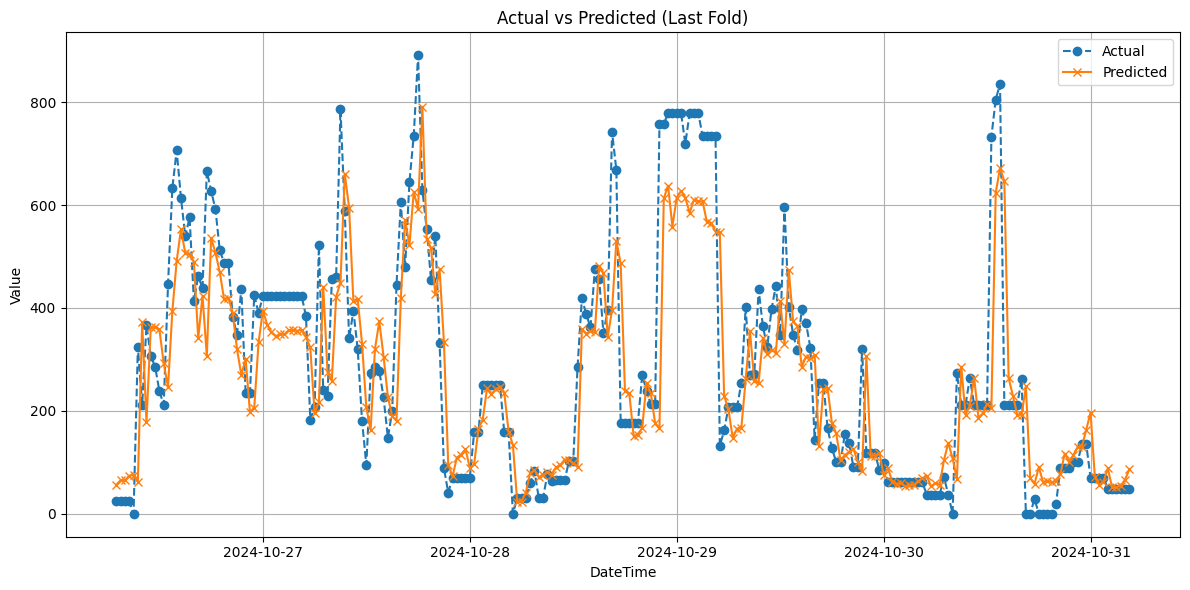

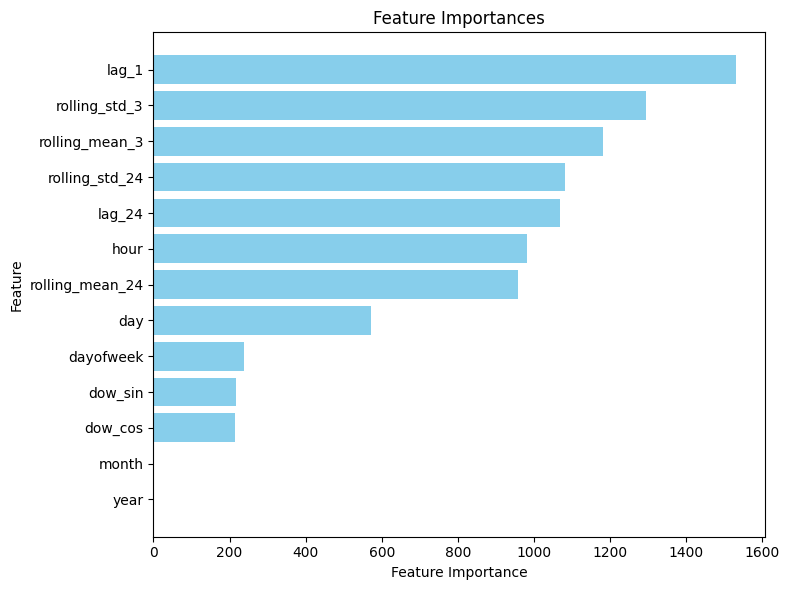

In [56]:
ML(wahington_)

[I 2024-12-16 18:45:16,977] A new study created in memory with name: no-name-b7602e2f-7ea8-4f20-b0e1-d6d561a09052
[I 2024-12-16 18:45:17,929] Trial 0 finished with value: 311262.85875364766 and parameters: {'learning_rate': 0.006045307128041643, 'num_leaves': 22, 'feature_fraction': 0.5950232340920913, 'bagging_fraction': 0.6396993550406698, 'bagging_freq': 1, 'lambda_l1': 4.083450004905527, 'lambda_l2': 2.639349032811029, 'min_child_samples': 59}. Best is trial 0 with value: 311262.85875364766.
[I 2024-12-16 18:45:18,817] Trial 1 finished with value: 948324.5873355053 and parameters: {'learning_rate': 0.0013965274596405104, 'num_leaves': 40, 'feature_fraction': 0.9629744948582903, 'bagging_fraction': 0.8001110596500733, 'bagging_freq': 4, 'lambda_l1': 1.2670925339715566, 'lambda_l2': 1.9814639422771452, 'min_child_samples': 68}. Best is trial 0 with value: 311262.85875364766.
[I 2024-12-16 18:45:19,848] Trial 2 finished with value: 227317.43761900254 and parameters: {'learning_rate': 

Best trial:
  Value:  92638.67136521937
  Params:  {'learning_rate': 0.014183024417783229, 'num_leaves': 119, 'feature_fraction': 0.8923804469055294, 'bagging_fraction': 0.974137184356825, 'bagging_freq': 6, 'lambda_l1': 4.438124521358988, 'lambda_l2': 5.3687663992616566, 'min_child_samples': 16}
チューニング後クロスバリデーション平均RMSE: 304.36601545707987
チューニング後クロスバリデーション平均R²: 0.9423223275753845
最後のスプリットでのRMSE: 263.943104018908
最後のスプリットでのR²: 0.9538554167291475


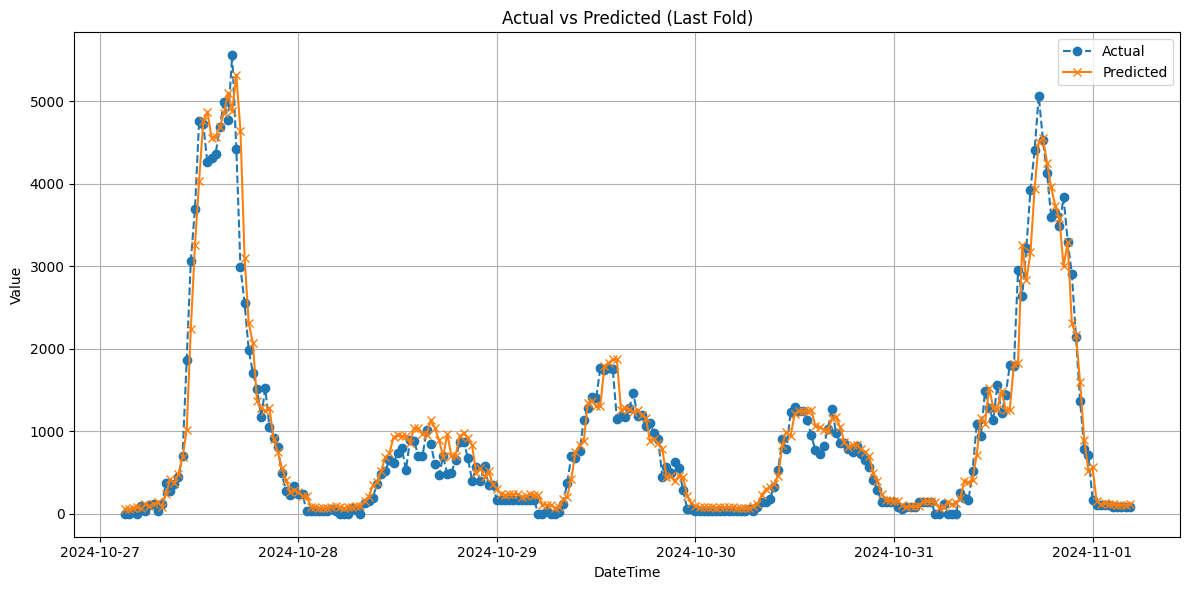

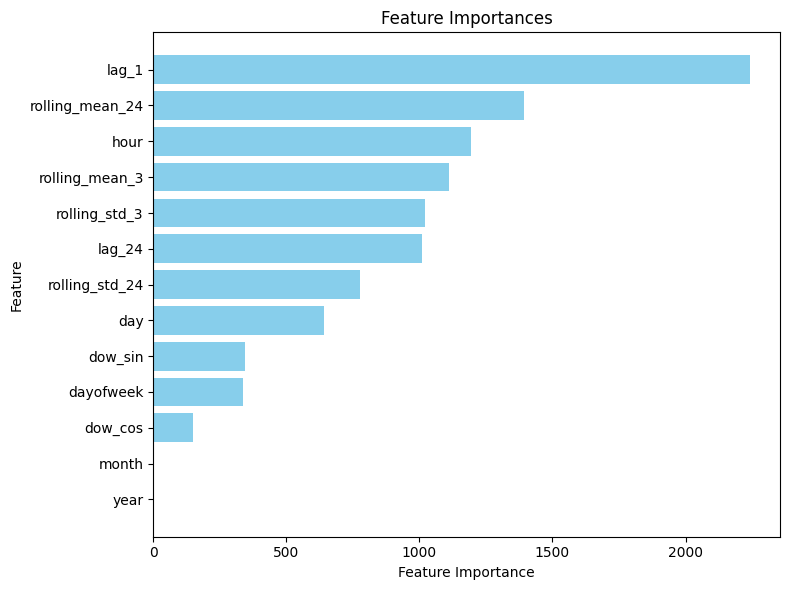

In [57]:
ML(ariake_)